### Turtles and Penguins Binary Classifier without Transfer Learning
#### Written by Dhruv Agrawal and Ariel Huang
#### COMP9517 Team Slayer Group Project

In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from tensorflow.python.training.saver import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [43]:
PATH_TO_TRAIN_IMAGES = "data/crop/train/"
PATH_TO_VALIDATION_IMAGES = "data/crop/val/"
PATH_TO_TEST_IMAGES = "data/crop/test/"

In [142]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_TRAIN_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_VALIDATION_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TO_TEST_IMAGES,
    batch_size=32,
    image_size=(96, 96)
)

class_names = train_dataset.class_names
print(class_names)

Found 4500 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 72 files belonging to 2 classes.
['penguin', 'turtle']


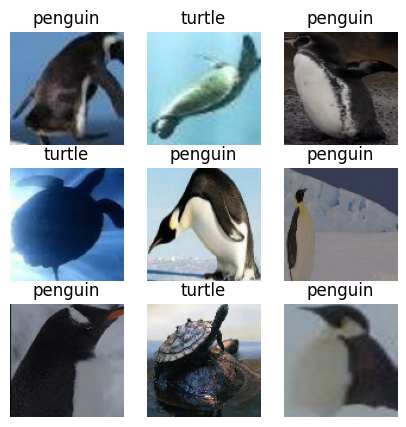

In [45]:
plt.figure(figsize=(5,5))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [82]:
# buffered prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [84]:
IMG_SHAPE = (50, 50) + (3,)
base_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (96, 96, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
])

base_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 10, 10, 256)      

In [85]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(96, 96, 3))

output = base_model(inputs)
output = global_average_layer(output)
output = prediction_layer(output)
output = tf.keras.layers.Dropout(0.2)(output)

model = tf.keras.Model(inputs, output)

In [86]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, 8, 8, 512)         1550976   
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
 dropout_4 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 1551489 (5.92 MB)
Trainable params: 1551489 (5.92 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [87]:
hist = model.fit(train_dataset, validation_data=val_dataset, batch_size=32, epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 604ms/step - loss: 25.2053 - accuracy: 0.5067 - val_loss: 0.8602 - val_accuracy: 0.4615
Epoch 2/100
7/7 [==============================] - 4s 566ms/step - loss: 0.6923 - accuracy: 0.5603 - val_loss: 0.8049 - val_accuracy: 0.5385
Epoch 3/100
7/7 [==============================] - 4s 560ms/step - loss: 0.6172 - accuracy: 0.6362 - val_loss: 0.5129 - val_accuracy: 0.8269
Epoch 4/100
7/7 [==============================] - 4s 569ms/step - loss: 0.5413 - accuracy: 0.7098 - val_loss: 0.4844 - val_accuracy: 0.7885
Epoch 5/100
7/7 [==============================] - 4s 589ms/step - loss: 0.4312 - accuracy: 0.7746 - val_loss: 0.4658 - val_accuracy: 0.7115
Epoch 6/100
7/7 [==============================] - 4s 571ms/step - loss: 0.6064 - accuracy: 0.6808 - val_loss: 0.5958 - val_accuracy: 0.7885
Epoch 7/100
7/7 [==============================] - 4s 569ms/step - loss: 0.4349 - accuracy: 0.7612 - val_loss: 0.2747 - val_accuracy: 0.8654
Epoch 8/100


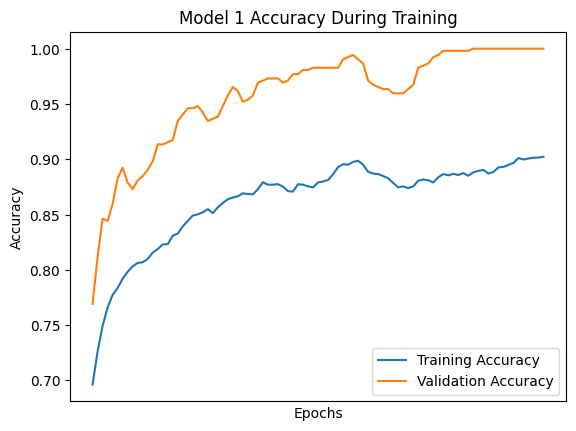

In [139]:
def moving_average(values, smoothing_over_epochs):
    return np.convolve(values, np.ones(smoothing_over_epochs), 'valid') / smoothing_over_epochs

AVERAGING = 10

train_accs = hist.history['accuracy']
train_graph = moving_average(train_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(train_graph))]

validation_accs = hist.history['val_accuracy']
val_graph = moving_average(validation_accs, AVERAGING)
epoch_range = [x + 1 for x in range(len(val_graph))]

plt.plot(np.asarray(epoch_range).astype(str), train_graph, label='Training Accuracy')
plt.plot(np.asarray(epoch_range).astype(str), val_graph, label='Validation Accuracy')
plt.xticks([])
plt.title('Model 1 Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Actual Labels:
 [1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0]
Predicted Labels:
 [1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0]


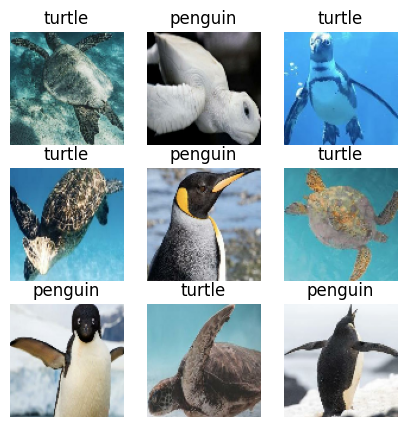

In [141]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Actual Labels:\n', label_batch)
print('Predicted Labels:\n', predictions.numpy())

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

1/1 [==============================] - 0s 36ms/step


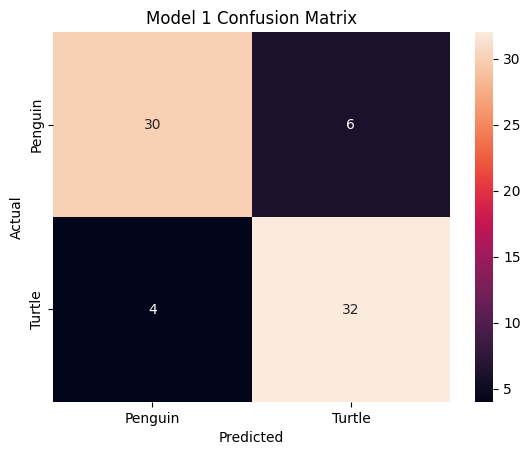

In [131]:
# confusion matrix
y_pred = []
y_true = []
for images, labels in test_dataset:
    y_pred.extend(tf.nn.sigmoid(model.predict(images)).numpy().flatten())
    y_true.extend(labels.numpy().flatten())

y_pred = np.asarray(y_pred)
y_pred = np.where(y_pred < 0.5, 0, 1)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=['Penguin', 'Turtle'], yticklabels=['Penguin', 'Turtle'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model 1 Confusion Matrix')
plt.show()

In [133]:
print('Classification Report')
print(sklearn.metrics.classification_report(y_true, y_pred, target_names=['Penguin', 'Turtle']))

Classification Report
              precision    recall  f1-score   support

     Penguin       0.88      0.83      0.86        36
      Turtle       0.84      0.89      0.86        36

    accuracy                           0.86        72
   macro avg       0.86      0.86      0.86        72
weighted avg       0.86      0.86      0.86        72



In [93]:
# save the model
model.save('classification_model_1')

INFO:tensorflow:Assets written to: classification_model_1/assets


INFO:tensorflow:Assets written to: classification_model_1/assets
